In [1]:
import sys  
sys.path.insert(1, 'functions/')
from ipynb.fs.full.interpolation_functions import *
import intake
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## read FESOM data

In [2]:
eerie_cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

In [3]:
data = eerie_cat['dkrz.disk.model-output.ifs-fesom2-sr.eerie-control-1950.ocean.native']['daily'].to_dask()

In [4]:
grid = eerie_cat['dkrz.disk.model-output.ifs-fesom2-sr.eerie-control-1950.ocean.native']['node_grid'].to_dask()
model_lon = grid.grid_center_lon.values
model_lat = grid.grid_center_lat.values
model_lon = np.where(model_lon>180, model_lon-360, model_lon)

In [6]:
# the data object contains data from 1950-01-01 to 1956-12-31. set
# startday and ntimesteps accordingly

ntimesteps = 10
startday = 0
a_ice = data.a_ice
u_ice = data.uice
v_ice = data.vice
path = '/work/bk1377/a270230/'
name = path + 'ice_fesom_1950.nc'

## read ICON data

In [20]:
data = eerie_cat["dkrz"]["disk"]["model-output"]["icon-esm-er"]["eerie-control-1950"]["ocean"]["native"]["2d_daily_mean"].to_dask()

In [92]:
grid = xr.open_dataset("/pool/data/ICON/grids/public/mpim/0016/icon_grid_0016_R02B09_O.nc", chunks="auto")
model_lon = grid.clon.values*180./np.pi
model_lat = grid.clat.values*180/np.pi

In [93]:
ntimesteps = 365
startday = 0
a_ice = data.conc[:,0,:]
u_ice = data.ice_u
v_ice = data.ice_v
path = '/work/bk1377/a270230/'
name = path + 'ice_icon_2002.nc'

## read NEMO data

In [2]:
nextgems_cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [3]:
data = nextgems_cat.IFS['IFS_9-NEMO_25-cycle3']['2D_1h_native'].to_dask()

In [4]:
model_lon = data.lon
model_lat = data.lat

In [5]:
ntimesteps = 5 # one year: 347*24 
startday = 0
a_ice = data['2t']
u_ice = data['10u']
v_ice = data['10v']
path = '/work/bk1377/a270230/'
name = path + 'ice_nemo.nc'

## interpolate and save as nc file

In [7]:
# create interpolation grid
box = (-180, 180, 60, 90)
res = (1000, 1000)
proj = 'np'
int_x_steps, int_y_steps, int_lons, int_lats = region_cartopy(box, res, proj)

# calculate distance to and index of the fesom grid point closest to
# the grid point in the interpolation grid
distances, inds = create_indexes_and_distances(model_lon, model_lat,
                                               int_lons, int_lats,
                                               k=1, workers=10)

# do the nearest neighbor interpolation
a_ice_int, u_ice_int, v_ice_int = interpolate(
    a_ice[startday:], u_ice[startday:], v_ice[startday:], inds, distances,
    ntimesteps, shape = int_lons.shape
)

create_nc_file(a_ice_int, u_ice_int, v_ice_int, int_lons, int_lats, ntimesteps,
           name)

0


## plot the interpolated data

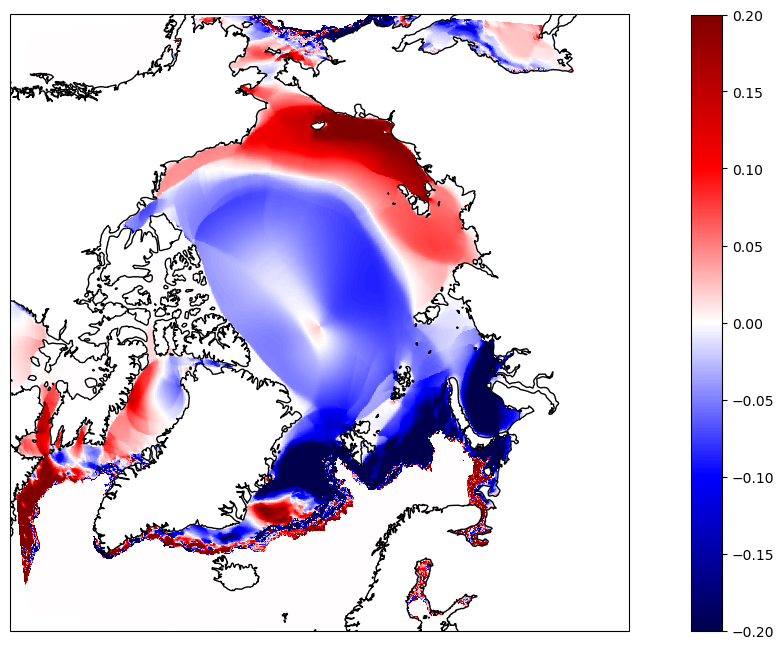

In [69]:
test = xr.open_dataset('ice_nemo.nc')

fig = plt.figure(figsize=[16, 8])
ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines(zorder=3)
im = ax.pcolormesh(test.ULON, test.ULAT,
                   test.U.isel(time=3),
                   cmap = 'seismic',
                   vmin=-0.2,vmax=0.2,
                   transform=ccrs.PlateCarree())
plt.colorbar(im)